# ML4L Workflow

The `ML4L` project is trying to use ML techniques to learn the land surface temperature (LST). 

This notebook attempts to track each stage of the project, from the raw data to the output plots, to enable reproducible research.

The only inputs a user needs to recreate this work is the raw data from ECMWF.

---
# Table of contents
1. [Raw Data](#rawdata) <br>

    1.1 [ERA5 data](#rawdataERA5) <br>
...1.1.1 [Processing ERA5 data](#rawdataERA5processing) <br>
    1.2 [MODIS data](#rawdataMODIS) <br>
    1.3 [Data Overview](#rawdataOverview) <br>
    
2. [Joining data](#joiningdata) <br>
3. [Training a Model](#trainingmodel) <br>
4. [Analysis and Visualisation](#analysis) <br>

    4.1 [Compare Models: V15 vs. V20](#analysiscompare) <br>


---

# 1. Raw Data <a name="rawdata"></a>
Any ML project needs data.

We can split this into two main categories: inputs and outputs.

Inputs are the features that go into our ML model. Outputs are the things we are trying to learn.

For this project:

* Inputs: ERA5 data

* Outputs: MODIS data

## 1.1 ERA5 Data <a name="rawdataERA5"></a>

We have a few different raw sources of ERA5 data provided by ECMWF.


These are:

* a) ERA_sfc
* b) ERA_skin
* c) ERA_skt
* d) climateV15
* e) climateV20
* f) Monthly lakes
* g) Salt lakes

Lets have a quick look at what these are like:



**a)** ERA_sfc. 6 years of data (2015-2021), hourly grain. Features: `sp, msl, 10u, 10v, 2t.` 

In [5]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_sfc/sfc_unstructured_2018_01.grib | head -10

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_sfc/sfc_unstructured_2018_01.grib
edition      centre       typeOfLevel  level        dataDate     stepRange    dataType     shortName    packingType  gridType     
1            ecmf         surface      0            20180101     0            an           sp           grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           msl          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           10u          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           10v          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           2t           grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           sp           grid_

**b)** ERA_skin. 10 years of data (2010-2020), hourly grain. Features: `aluvp,aluvd,alnip ,alnid,cl,cvl,cvh,istl1,istl2,slt,sdfor,z,sd,sdor,isor,anor,slor
2d,lsm,fal`



In [4]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib | head -25

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib
edition      centre       typeOfLevel  level        dataDate     stepRange    dataType     shortName    packingType  gridType     
1            ecmf         surface      0            20180101     0            an           aluvp        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           aluvd        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           alnip        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           alnid        grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           cl           grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           cvl         

**c)** ERA_skt. 6 years of data (2015-2022), hourly grain. Features: `skt`

In [14]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skt/skt_unstructured_2018_01.grib | head -5

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skt/skt_unstructured_2018_01.grib
edition      centre       typeOfLevel  level        dataDate     stepRange    dataType     shortName    packingType  gridType     
1            ecmf         surface      0            20180101     0            an           skt          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           skt          grid_simple  reduced_gg  
1            ecmf         surface      0            20180101     0            an           skt          grid_simple  reduced_gg  


**d)** climateV15. Some additional constant in time features. Overlaps with some data we already have.

In [1]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/clake
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/lsmoro
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/sfc
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/lakedl

! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/cvh
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/cvl
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/cicecap

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/clake
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20131129     an           reduced_gg   0            surface      0            cl           grid_simple 
1 of 1 messages in /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/clake

1 of 1 total messages in 1 files
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v015/climate.v015/639l_2/lsmoro
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20151011     an           reduced_gg   0            surface      0            lsm          grid_simple 
2            ecmf         20151011     an           reduced_gg   0            surface      

**e)** climateV20. More up to date fields of above:

In [294]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/clake
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/lsmoro
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/sfc
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/lakedl

! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/cvh
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/cvl
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/cicecap

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/clake
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20110131     af           reduced_gg   0            surface      0            cl           grid_simple 
1 of 1 messages in /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/clake

1 of 1 total messages in 1 files
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/climate.v020/climate.v020/639l_2/lsmoro
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20210222     an           reduced_gg   0            surface      0            lsm          grid_simple 
2            ecmf         20210222     an           reduced_gg   0            surface      

**f)** Monthly lakes. Monthly values of the lake parameter `cl`

In [8]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/BonusClimate/clake_639l2_month01


/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/BonusClimate/clake_639l2_month01
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20110131     af           reduced_gg   0            surface      0            cl           grid_simple 
1 of 1 messages in /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/BonusClimate/clake_639l2_month01

1 of 1 total messages in 1 files


**g)** Salt lake maps

In [57]:
! grib_ls /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/saltlakes_max/clake_639l2_yearMAX_saline

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/saltlakes_max/clake_639l2_yearMAX_saline
edition      centre       date         dataType     gridType     stepRange    typeOfLevel  level        shortName    packingType  
2            ecmf         20110131     af           reduced_gg   0            surface      0            cl           grid_simple 
1 of 1 messages in /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/saltlakes_max/clake_639l2_yearMAX_saline

1 of 1 total messages in 1 files


We also have the salt lake maps `/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/saltlakes/clake_639l2_year_saline` which are superseded by the max extent maps

## 1.2 MODIS Data <a name="rawdataMODIS"></a>

The MODIS data requires less (or rather no!) processing than the ERA5 data.

Daily `.tiff` files are found at `/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/` and are easy to load and process.

We have MODIS data covering the period 2015 - 2021.


## 2. Processing Raw Data <a name="rawdataERA5processing"></a>


We can leave the MODIS data "as is" - it is in a consistent easily accesible format ✅ .

The raw ERA data is spread among distinct files, with some overlap and degeneracy between files; some files holding the same features and we are needlessly holding values all of features which are constant in time.

It will be useful to bring this data all together into a consistent, easily usable format.

Now, `ERA_sfc` and `ERA_skt` are "well-behaved" and hold only time-variable features that are not held in other files.

However `ERA_skin` holds features which are already in the climateV files. Does it also hold additional features which are constant in time?

Given all this data in disparate files, it will be useful to bring it all together in 




 both  ✅

What about the other time-varable file, 


In [243]:
import xarray as xr
import numpy as np
import pandas as pd

example_ERA_skin_file = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib'

def check_if_variables_are_constant(ds): 
    """For all the variables in this ds, are they constant in time for each grid point?"""
    
    #Get all variables/features
    #all_variables = list(ds.keys())
    all_variables = [i for i in ds_skin.keys()]


    names = []
    variations = []
    for v in all_variables:
    
        a = ds[v].values
        #a == a[0,:] compares each value to the corresponding value in the first row
        #A column shares a common value if all the values in that column are True
        is_constant = all(np.all(a == a[0,:], axis = 0))
        
        
        print (v,is_constant)
        names.extend([v])
        variations.extend([is_constant])
        

In [231]:
ds_skin = xr.open_dataset(example_ERA_skin_file,engine='cfgrib',filter_by_keys={'typeOfLevel': 'surface'}, backend_kwargs={'indexpath': ''} ) 
print('File loaded')
check_if_variables_are_constant(ds_skin)


File loaded


TypeError: 'list' object is not callable

In [ ]:
check_if_variables_are_constant(ds_skin)


aluvp False
aluvd False
alnip False
alnid False
cl True
cvl True
cvh True
slt True
sdfor True
z True
sd False
sdor True
isor True
anor True
slor True
d2m False
lsm True


In [241]:
ds_skin.aluvp.values


array([[0.05999196, 0.05999196, 0.05999196, ..., 0.1499883 , 0.1499883 ,
        0.1499883 ],
       [0.05999244, 0.05999244, 0.05999244, ..., 0.14998877, 0.14998877,
        0.14998877],
       [0.05999291, 0.05999291, 0.05999291, ..., 0.14998925, 0.14998925,
        0.14998925],
       ...,
       [0.06000421, 0.06000421, 0.06000421, ..., 0.15000054, 0.15000054,
        0.15000054],
       [0.05999145, 0.05999145, 0.05999145, ..., 0.14998779, 0.14998779,
        0.14998779],
       [0.05999395, 0.05999395, 0.05999395, ..., 0.14999029, 0.14999029,
        0.14999029]], dtype=float32)

In [504]:
#ERA skin. Filter out istl1,2 else errors.
ds_skin = xr.open_dataset(example_ERA_skin_file,engine='cfgrib',filter_by_keys={'typeOfLevel': 'surface'}, backend_kwargs={'indexpath': ''} ) 
check_if_variables_are_constant(ds_skin)


#Now deal with istl1,2 individually
ds_istl1 = xr.open_dataset(example_ERA_skin_file,engine='cfgrib',filter_by_keys={'shortName': 'istl1'}, backend_kwargs={'indexpath': ''} ) 
check_if_variables_are_constant(ds_istl1)

ds_istl2 = xr.open_dataset(example_ERA_skin_file,engine='cfgrib',filter_by_keys={'shortName': 'istl2'}, backend_kwargs={'indexpath': ''} ) 
check_if_variables_are_constant(ds_istl2)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_42515/758809054.py", line 2, in <module>
    ds_skin = xr.open_dataset(example_ERA_skin_file,engine='cfgrib',filter_by_keys={'typeOfLevel': 'surface'}, backend_kwargs={'indexpath': ''} )
  File "/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/xarray/backends/api.py", line 499, in open_dataset
    **kwargs,
  File "/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/cfgrib/xarray_plugin.py", line 109, in open_dataset
    extra_coords=extra_coords,
  File "/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/cfgrib/xarray_plugin.py", line 39, in __init__
    self.ds = opener(filename, **backend_kwargs)
  File "/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/cfgrib/dataset

TypeError: object of type 'NoneType' has no len()

We have just demonstrated a month of data here, but it is straightforward to extend to multiple months and the conclusions are unchanged.

All variables in `ERA_sfc` are time variable, as is `ERA_skt`.

In `ERA_skin`:

* Time Variable: `aluvp,aluvd,alnip,alnid,istl1,istl2,sd,2d,fal`
* Time Constant: `cl,cvl,cvh,slt,sdfor,z,sdor,isor,anor,slor,lsm`
---


With the features which are (not)constant in time identified we need to take the following steps:

For each month: 
* Extract the time variable features from ERA skin: `aluvp,aluvd,alnip,alnid,istl1,istl2,sd,2d,fal`
* Merge the time variable ERA skin, ERA surface and ERA skt into a single 'time variable' file.

This is done in `scripts/process_time_variable_data.py`.
    
For one month:
* Extract the constant time features from ERA skin, that are not covered in climateV15, climateV20: `slt,sdfor`
* Bring together with the climateV15,climateV20 and yearlyCL (`vegdiff`) data.

This is done in `scripts/process_time_constant_data.py`.

The final outputs of ERA data are then

* `ERA_time_variable` * nmonths. GRIB format. `processed_data/ERA_timevariable`
* `ERA_constant_V15` * 1. NetCDF format. `processed_data/ERA_timeconsant`
* `ERA_constant_V20` * 1. NetCDF format. `processed_data/ERA_timeconsant`
*  Monthly 'bonus' data `raw/BonusClimate/`, NOT `yearlyCL`

The complete list of features is:

In [182]:
feature_names = ['sp', 'msl', 'u10', 'v10', 't2m',                                   # ERA_sfc, Time Variable
            'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m','fal', # ERA_skin, Time Variable
            'skt',                                                                   # ERA skt, Time Variable
            'lsm',  'slt', 'sdfor','lsrh', 'cvh',  'z', 'isor', 'sdor', 'cvl','cl','anor', 'slor', 'sr', 'tvh', 'tvl' #climatev15,v20 constant
            'vegdiff',                                                               #Bonus data
            'COPERNICUS/', 
            'CAMA/',
            'ORCHIDEE/', 
             'monthlyWetlandAndSeasonalWater_minusRiceAllCorrected_waterConsistent/',
             'CL_ECMWFAndJRChistory/'
            ]

import requests
import pandas as pd

r = requests.get("https://apps.ecmwf.int/codes/grib/json/").json()['parameters']

def param_name(x,r):
    try:
        d = next(item for item in r if item["param_shortName"] == x)
        name = d['param_name']
        units = d['units_name']
    except:
        #maybe naming convention is different
        name = 'Null'
        units = 'Null'
    
    return f'{x}: {name} : {units}'


for i in feature_names:
    print(param_name(i,r))

sp: Wind speed (SP) : m s**-1
msl: Mean sea level pressure : Pa
u10: Null : Null
v10: Null : Null
t2m: Null : Null
aluvp: UV visible albedo for direct radiation : (0 - 1)
aluvd: UV visible albedo for diffuse radiation : (0 - 1)
alnip: Near IR albedo for direct radiation : (0 - 1)
alnid: Near IR albedo for diffuse radiation : (0 - 1)
istl1: Ice temperature layer 1 : K
istl2: Ice temperature layer 2 : K
sd: Snow depth water equivalent : kg m**-2
d2m: Null : Null
fal: Forecast albedo : (0 - 1)
skt: Skin temperature : K
lsm: Land-sea mask : (0 - 1)
slt: Soil type : ~
sdfor: Standard deviation of filtered subgrid orography : m
lsrh: Logarithm of surface roughness length for heat : ~
cvh: High vegetation cover : (0 - 1)
z: Geopotential : m**2 s**-2
isor: Anisotropy of sub-gridscale orography : ~
sdor: Standard deviation of orography : m
cvl: Low vegetation cover : (0 - 1)
cl: Lake cover : (0 - 1)
anor: Angle of sub-gridscale orography : radians
slor: Slope of sub-gridscale orography : ~
sr: 

Note there could be some errors in these definitions. For instance, `sp` is surface pressure according to [ECMMWF param database](https://apps.ecmwf.int/codes/grib/param-db/), but the json request returns it as wind speed...? Nulls occur when the feature names we are using don't match with those in database.

# 2. Processing Raw Data <a name="rawdata_process"></a>


## 1.3 Data Overview <a name="rawdataOverview"></a>

It is useful for the intution to have a quick look at each of our data sources: 

* ERA5 time variable:

In [46]:
f = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timevariable/ERA_0.grib'
ERA5_timevariable = xr.open_dataset(f,engine='cfgrib',backend_kwargs={'indexpath': ''} )
display(ERA5_timevariable)

<xarray.Dataset>
Dimensions:              (time: 744, values: 542080)
Coordinates:
    number               int64 ...
  * time                 (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:0...
    step                 timedelta64[ns] ...
    surface              float64 ...
    latitude             (values) float64 ...
    longitude            (values) float64 ...
    valid_time           (time) datetime64[ns] ...
    depthBelowLandLayer  float64 ...
Dimensions without coordinates: values
Data variables: (12/15)
    sp                   (time, values) float32 ...
    msl                  (time, values) float32 ...
    u10                  (time, values) float32 ...
    v10                  (time, values) float32 ...
    t2m                  (time, values) float32 ...
    aluvp                (time, values) float32 ...
    ...                   ...
    istl1                (time, values) float32 ...
    istl2                (time, values) float32 ...
    sd                   (time, values) float32 ...
    d2m                  (time, values) float32 ...
    fal                  (time, values) float32 ...
    skt                  (time, values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-04-10T15:29 GRIB to CDM+CF via cfgrib-0.9.1...

* ERA5 time constant, v15 and v20:

In [47]:
f = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/ERA_timeconstant/ERA_constants_v15.nc'
ERA5_timevariable = xr.open_dataset(f)
display(ERA5_timevariable)

<xarray.Dataset>
Dimensions:     (time: 1, values: 542080)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2018-01-01
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (values) float64 ...
    longitude   (values) float64 ...
    valid_time  (time) datetime64[ns] ...
Dimensions without coordinates: values
Data variables: (12/15)
    slt         (time, values) float32 ...
    sdfor       (time, values) float32 ...
    lsrh        (values) float32 ...
    cvh         (values) float32 ...
    lsm         (values) float32 ...
    z           (values) float32 ...
    ...          ...
    cl          (values) float32 ...
    anor        (values) float32 ...
    slor        (values) float32 ...
    sr          (values) float32 ...
    tvh         (values) float32 ...
    tvl         (values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-04-10T13:00 GRIB to CDM+CF via cfgrib-0.9.1...

* ERA Bonus

* MODIS

In [48]:
f = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/aquaDay_errorGTE03K_04km_2018-01-01.tif'
MODIS_data = xr.open_dataarray(f,engine="rasterio")
display(MODIS_data)

<xarray.DataArray 'band_data' (band: 1, y: 5400, x: 10800)>
[58320000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 180.0 180.0
  * y            (y) float64 89.98 89.95 89.92 89.88 ... -89.92 -89.95 -89.98
    spatial_ref  int64 ...
Attributes:
    long_name:  LST_Day_1km

---
# 2. Joining Data <a name="joiningdata"></a>


We have our inputs `ERA` and our outputs `MODIS` in a nice clean form.

We now need to join these two data sources in both space and time.

What this means is, for a bunch of ERA features at time `t` and grid point `x` what is the corresponding real-world observation provided by MODIS?

This is implemented in `scripts/join_MODIS_with_ERA.py`

The general method is as follows:

* Load a day of MODIS data

* Apply latitude bounds (|lat| < 70), calculate the 'absolute' UTC from the longitude and filter this data to an hour time slice.

* Load a month of ERA data. This includes ERA time variable, ERA constant and ERA bonus.

* Filter this data to an hour. 

* Use `faiss_knn()` to join ERA_hour + MODIS_hour in space. `faiss_knn()` implements a GPU accelerated k nearest neighbours algo. See https://github.com/facebookresearch/faiss . 
    * For each MODIS data point, find the nearest ERA grid point, where nearness is an L2 (squared) norm on the lat/long coordinates.
    * Filter out those matches where the Haversine distance is > 50 km
    * We now have multiple MODIS data points for each ERA grid point. Groupby and take an average


Monthly joined data is written to `processed_data/joined_data`.

Also note:

* In practice, matching 3 years of data takes 7 hours. There may be a more efficient way to do this - for now we will settle with this as "good enough", as the matching only needs to be done once.

* During the matching process, we also carry all the ERA features, both constant and time variable. This is not strictly necessary, it could be more efficient to just carry the $(\bar{x},t)$ and bring the features in later, but in practice this approach works well.




With `scripts/join_MODIS_with_ERA.py` having completed successfully, we can can visualise the output of the matching by plotting hourly snapshots of data as follows:

In [321]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

example_month = pd.read_pickle('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/V2matched_0.pkl')

print(example_month.columns)
def plot_map(df,x,y,q): #slow plotting function using geopandas
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]))
    
    #Plot the world
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.boundary.plot(figsize=(24,12))
    
    gdf.plot(ax=ax,column=q,cmap='plasma',markersize=1,legend=True)
    
    
    plt.show()

Index(['latitude_ERA', 'longitude_ERA', 'latitude_MODIS', 'longitude_MODIS',
       'MODIS_LST', 'sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd',
       'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m', 'fal', 'skt',
       'slt_v15', 'sdfor_v15', 'vegdiff_v15', 'lsrh_v15', 'cvh_v15',
       'isor_v15', 'dl_v15', 'lsm_v15', 'z_v15', 'si10_v15', 'sdor_v15',
       'cvl_v15', 'anor_v15', 'slor_v15', 'sr_v15', 'tvh_v15', 'tvl_v15',
       'cl_v15', 'slt_v20', 'sdfor_v20', 'vegdiff_v20', 'lsrh_v20', 'cvh_v20',
       'isor_v20', 'dl_v20', 'lsm_v20', 'z_v20', 'si10_v20', 'sdor_v20',
       'cvl_v20', 'anor_v20', 'slor_v20', 'sr_v20', 'tvh_v20', 'tvl_v20',
       'cl_v20', 'COPERNICUS/', 'CAMA/', 'ORCHIDEE/',
       'monthlyWetlandAndSeasonalWater_minusRiceAllCorrected_waterConsistent/',
       'CL_ECMWFAndJRChistory/', 'heightAboveGround', 'L2_distance',
       'H_distance', 'time'],
      dtype='object')


In [2]:
import pandas as pd
example_month = pd.read_pickle('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/MAYmatched_0.pkl')

In [7]:
example_month[['cl_v15','cl_v20','clake_monthly_value']]

cl_v15    cl_v20  clake_monthly_value
0       0.0  0.008516             0.009874
1       0.0  0.001384             0.003617
2       0.0  0.001968             0.005533
3       0.0  0.000107             0.000549
4       0.0  0.001032             0.011444
..      ...       ...                  ...
922     0.0  0.038720             0.038017
923     0.0  0.000111             0.000148
924     0.0  0.014523             0.015175
925     0.0  0.011842             0.011993
926     0.0  0.000532             0.000405

[3048183 rows x 3 columns]

2018-01-01T10:00:00.000000000


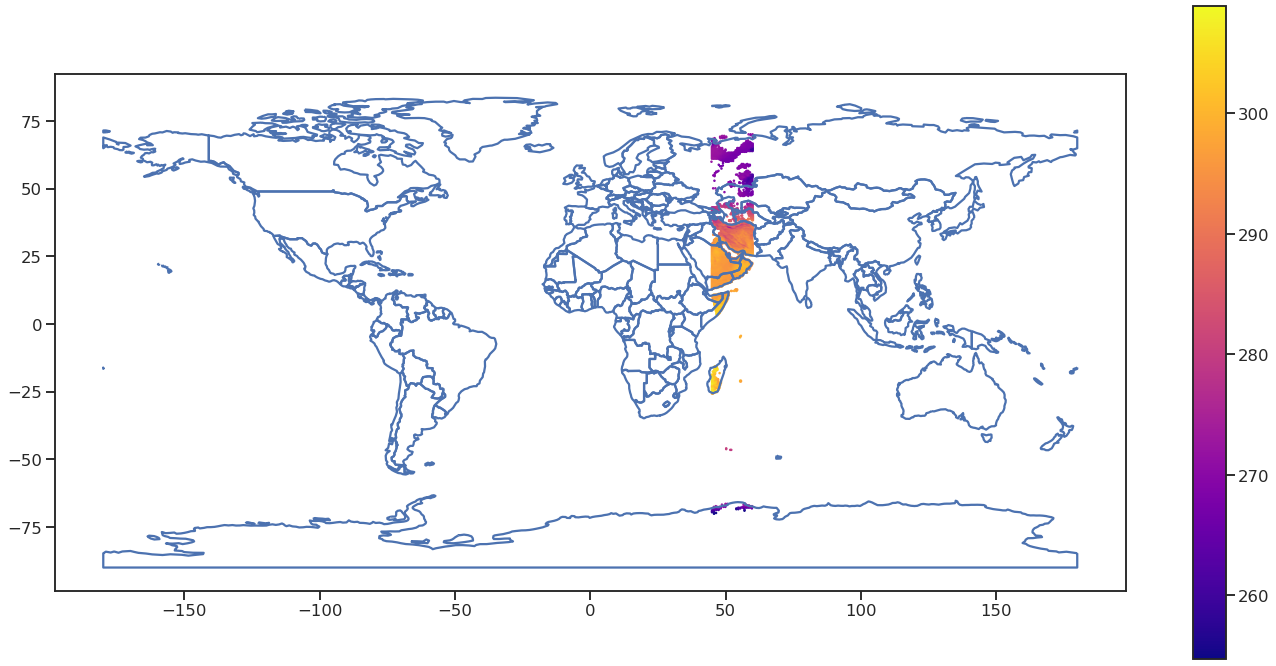

2018-01-01T11:00:00.000000000


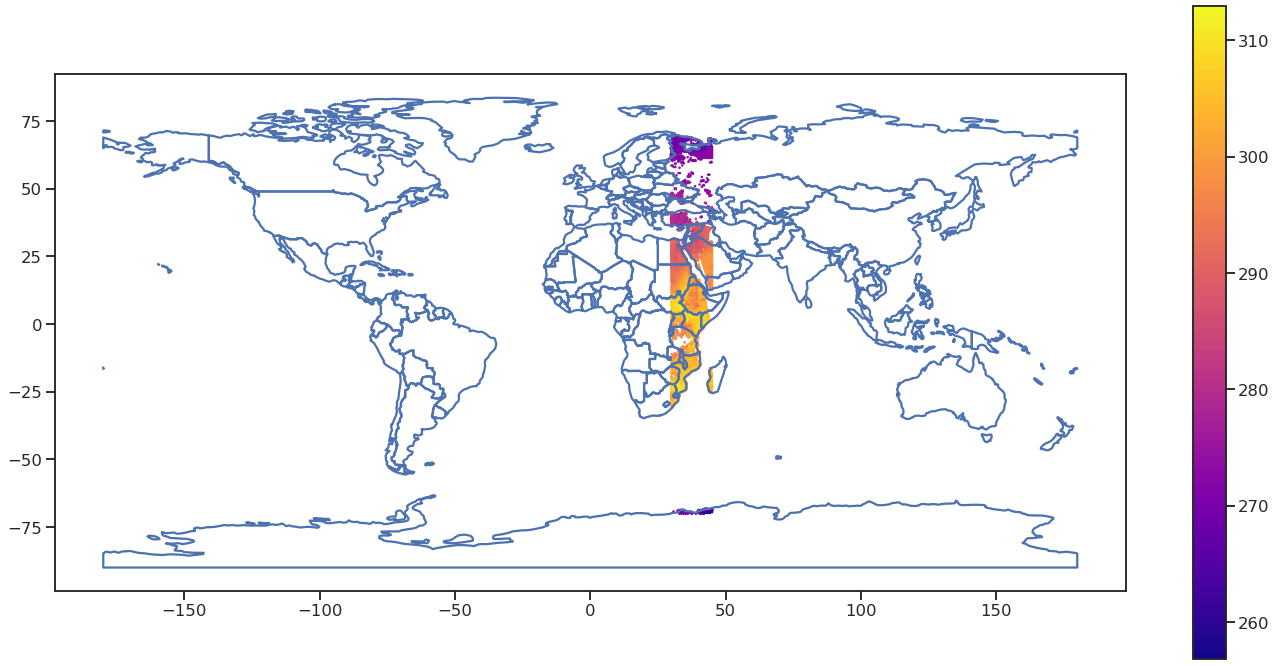

2018-01-01T12:00:00.000000000


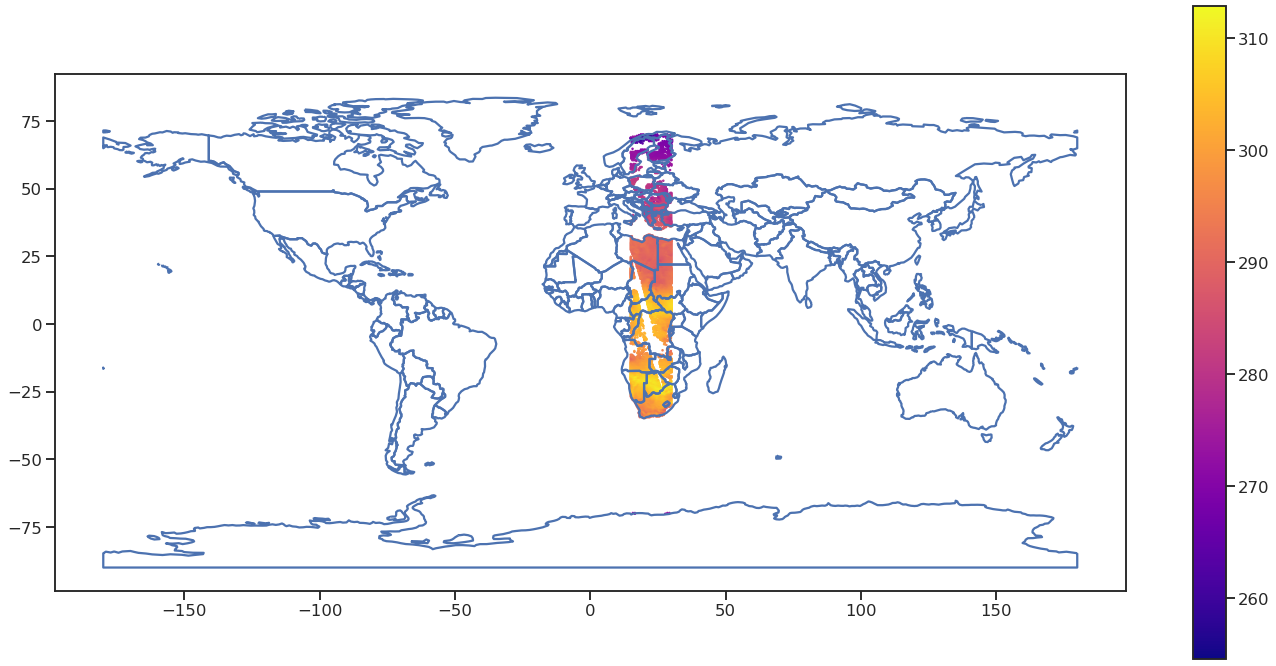

2018-01-01T13:00:00.000000000


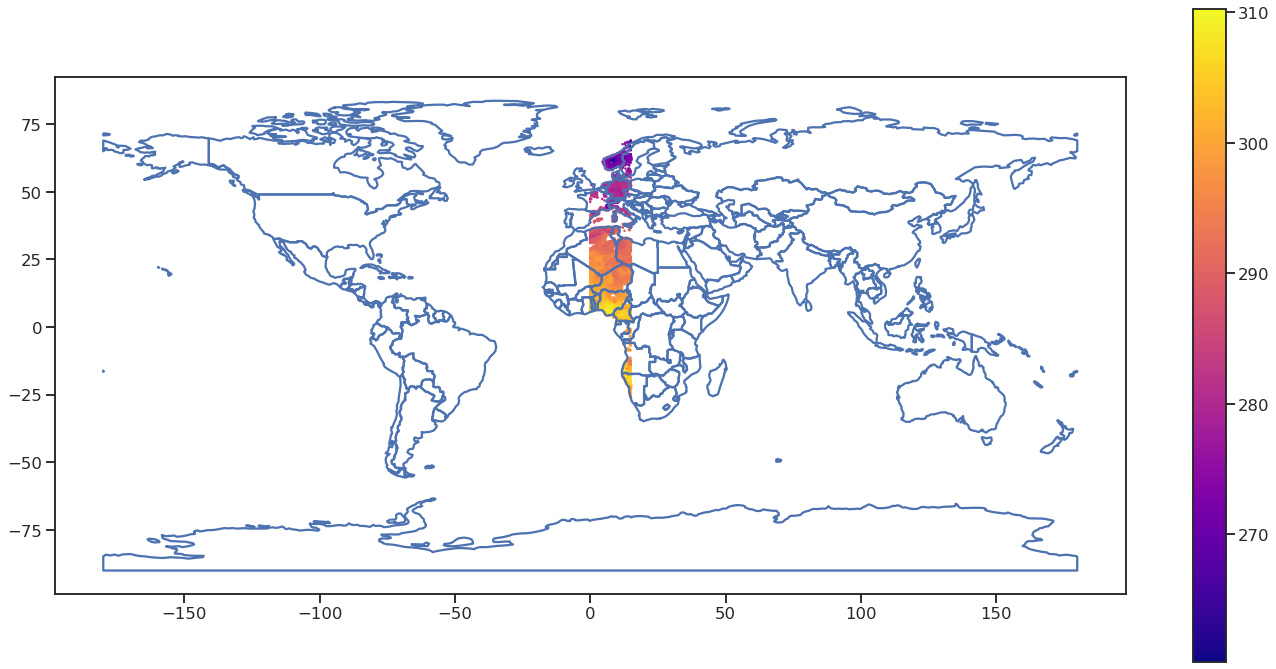

2018-01-01T14:00:00.000000000


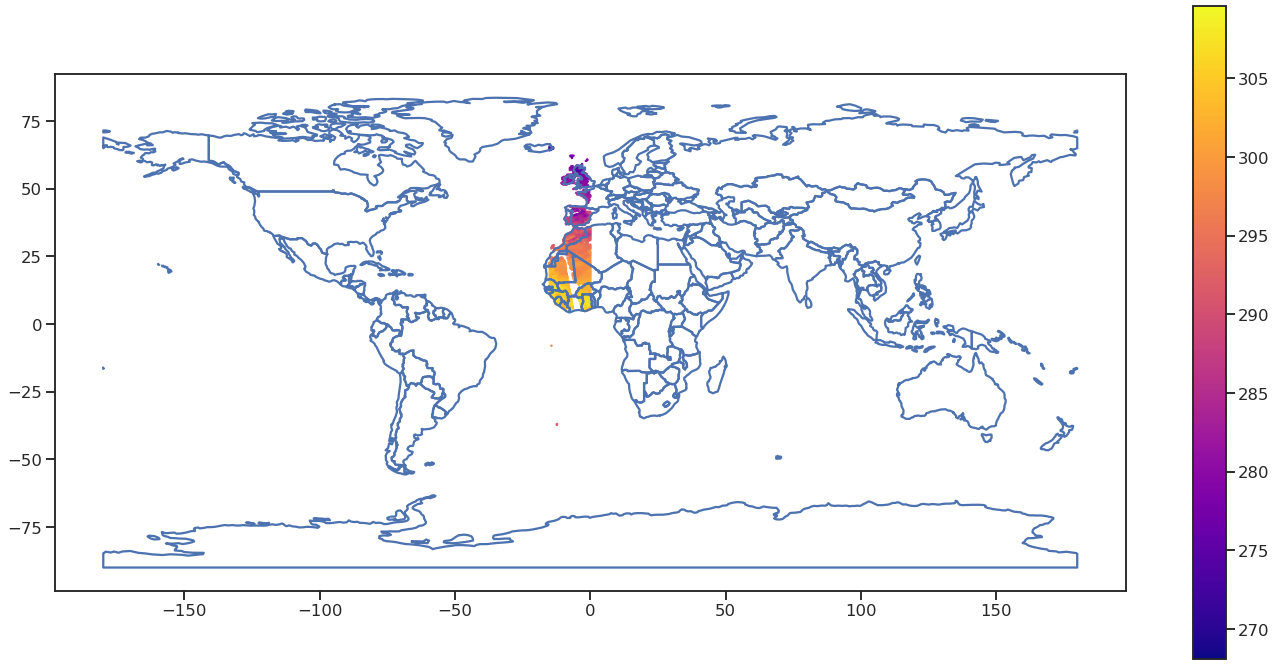

2018-01-01T15:00:00.000000000


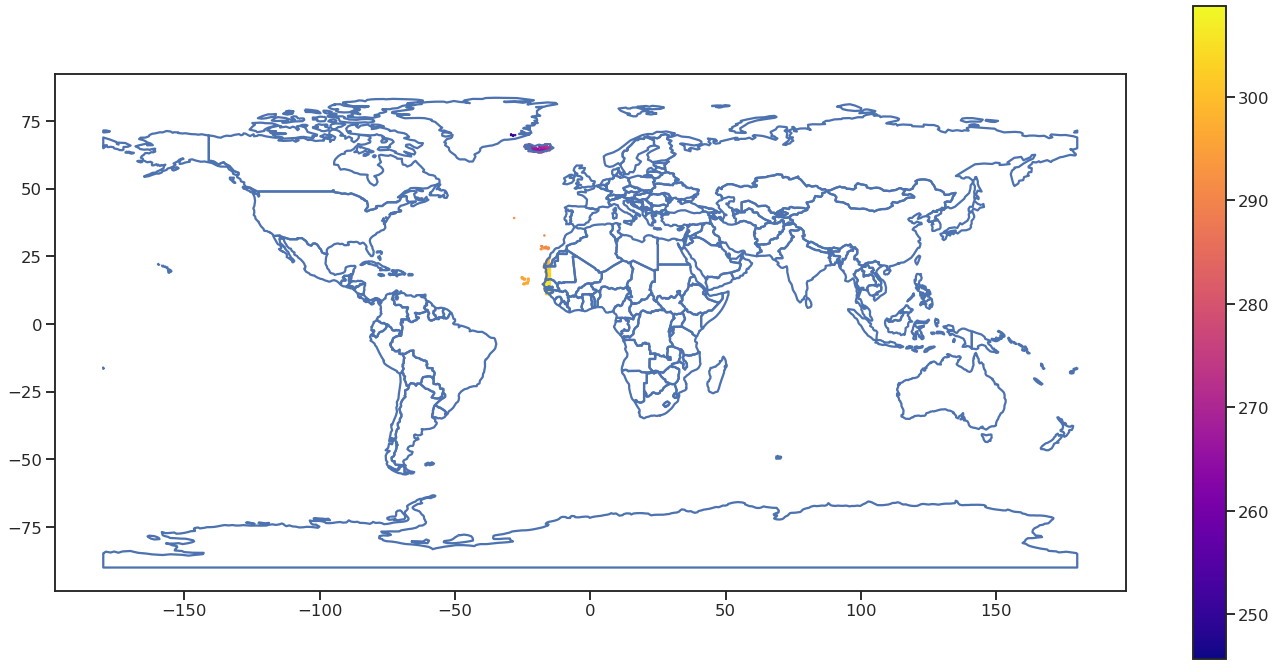

2018-01-01T16:00:00.000000000


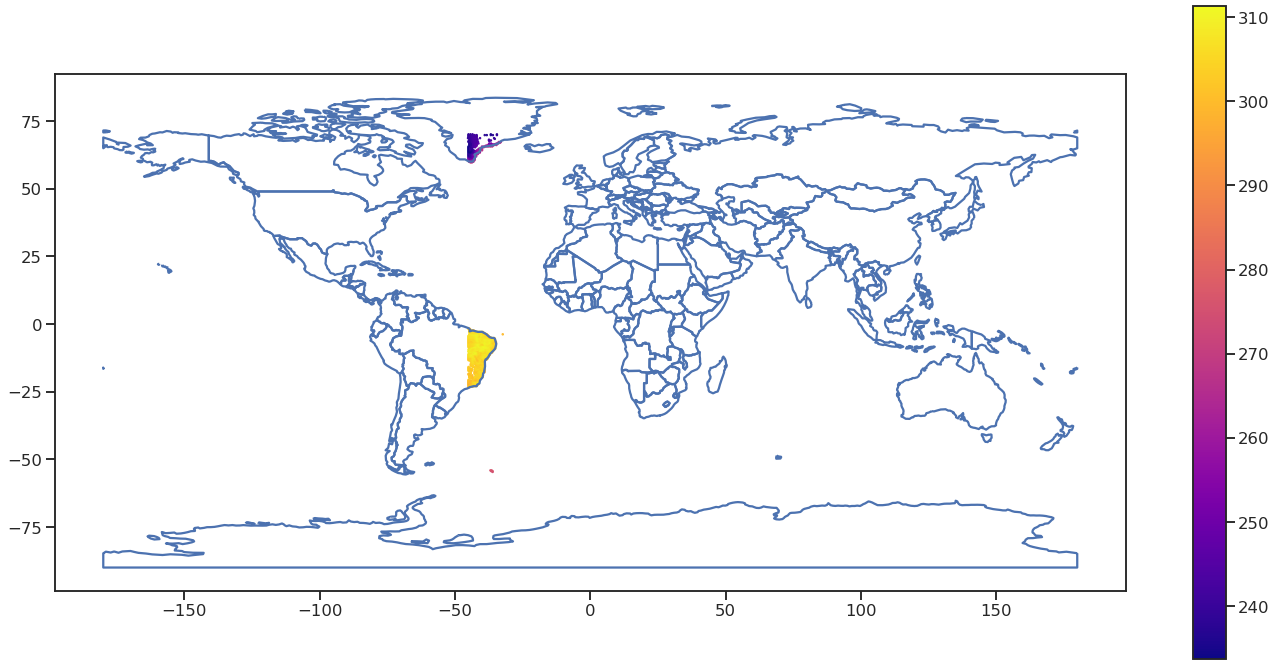

2018-01-01T17:00:00.000000000


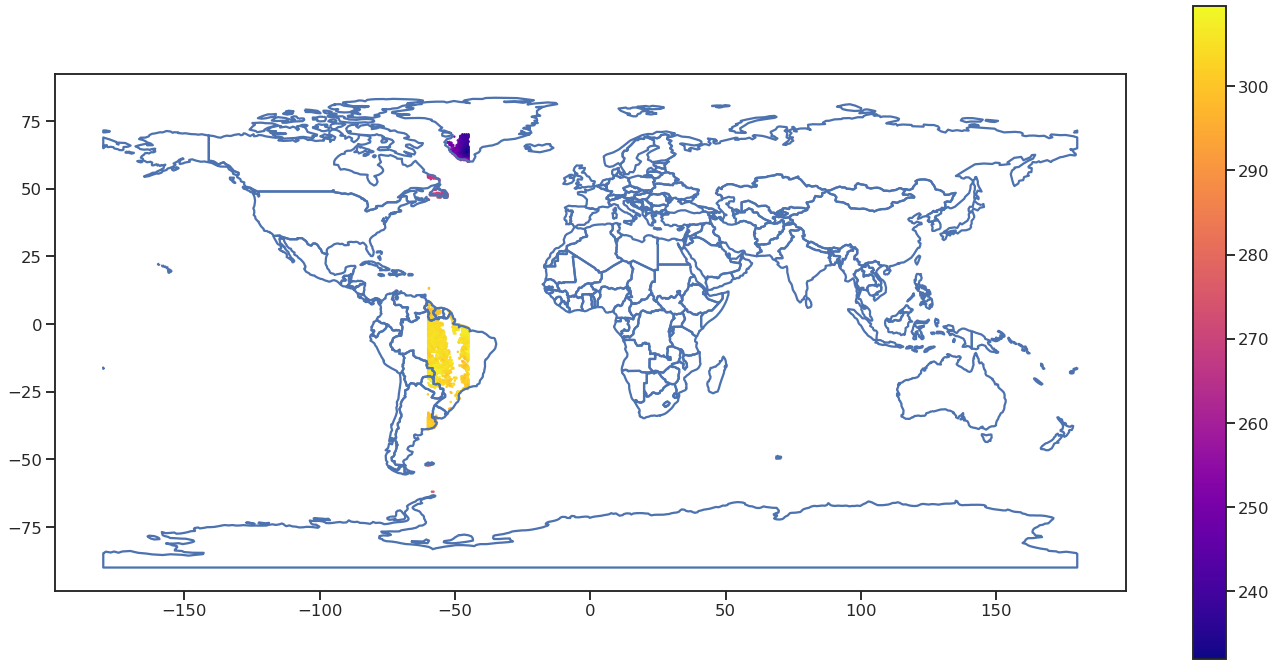

In [276]:
%matplotlib inline

times = example_month.time.unique()
for t in times[8:16]: #for a selection of hours
    print(t)
    df_hour = example_month.query(f'time == "{t}"')
    plot_map(df_hour,'longitude_ERA', 'latitude_ERA', 't2m')


And we can also look at a 24 hour period of data:

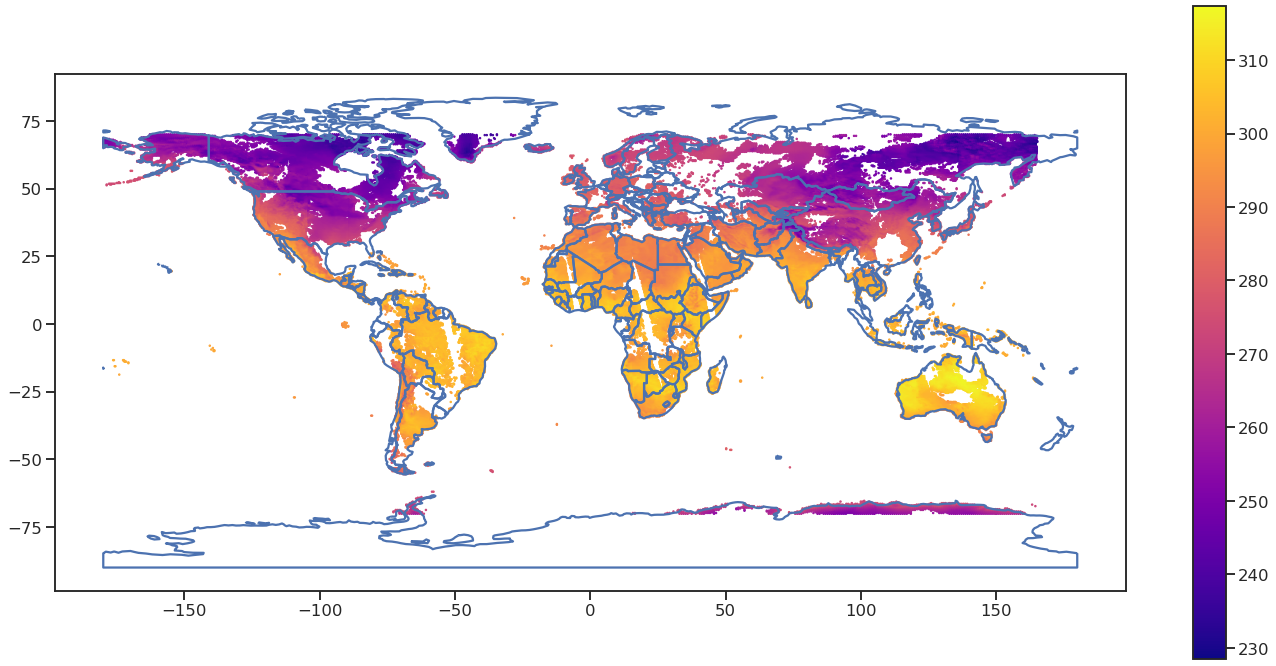

In [222]:
start_time = times[0]
end_time = times[24]
df_day = example_month.query(f'time > "{start_time}" & time < "{end_time}"')
plot_map(df_day,'longitude_ERA', 'latitude_ERA', 't2m')


Since the monthly files are not too large (~800 MB), it is useful to bring them all together into a single joined data file: `scripts/unify_monthly_matches.py`. 


This provides a single file which we will use for training/testing our model: `all_months.h5`

---


# 3. Training a Model <a name="trainingmodel"></a>


Given our single dataframe relating features to outputs we are now in a position to train a model.

We use 2018 as training data, 2020 as test data, holding 2019 as a validation set.

A model is trained and then makes predictions in `scripts/train_and_predict.py`

The model uses [Tensorflow](https://www.tensorflow.org/) to construct a sequential, tapered NN with 1 hidden layer. 

We output:
* Trained model, including the history 
* The model predictions, `predictions.pkl`
* Some useful meta data `meta.txt`

---

# 4. Analysis and Visualisation <a name="analysis"></a>


With a model trained we can plot:

* Training history
* Distribution of prediction errors (and compare errors with ERA SKT)
* Map of prediction errors

For example:

In [328]:

import matplotlib.colors as mc
import matplotlib.colorbar as cb 
import matplotlib.pyplot as plt
import json
import seaborn as sns
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs


def plot_training_history(path,logscale,jump_n_epochs):
    
    with open(path+'meta.txt') as f:
        lines = f.readlines()
        print(*lines)
        #print( [row for row in lines])
    
    
    
    
    with open(path+'history.json') as f:
        d = json.load(f)

        i = jump_n_epochs
        training_loss = d['loss'][i:]
        epochs = np.arange(len(training_loss))
        
        

        

        fig = plt.figure(figsize=(10, 10))
        plt.plot(epochs,training_loss,label='training loss')
        try:
            validation_loss = d['val_loss'][i:]
            plt.plot(epochs,validation_loss, label='validation loss')
        except:
            pass
        plt.legend()
        
        if logscale:
            plt.yscale('log')

def load_predictions(path, print_errors):

    df = pd.read_pickle(path+'predictions.pkl')

    #Create some new columns for the errors
    df['error_ERA'] = df.MODIS_LST - df.skt
    df['error_ERA_abs'] = abs(df.MODIS_LST - df.skt)

    df['error_NN'] = df.MODIS_LST - df.predictions
    df['error_NN_abs'] = abs(df.MODIS_LST - df.predictions)

    df['NN_vs_ERA'] = df['error_NN_abs'] - df['error_ERA_abs']

    #Surface some useful numbers
    
    if print_errors:
        print('Absolute error:')
        print('--------------------------------')
        print("NN model: Mean error, Median error, Std deviation:",df.error_NN_abs.mean(), df.error_NN_abs.median(),df.error_NN_abs.std())
        print("ERA5: Mean error, Median error, Std deviation    :", df.error_ERA_abs.mean(), df.error_ERA_abs.median(),df.error_ERA_abs.std())

        print('Biased error:')
        print('--------------------------------')
        print("NN model: Mean bias, Median bia, Std deviation:",df.error_NN.mean(), df.error_NN.median(),df.error_NN.std())
        print("ERA5: Mean bias, Median bias, Std deviation::    ", df.error_ERA.mean(), df.error_ERA.median(),df.error_ERA.std())
        print('--------------------------------')


    return df
    
def plot_error_map_old_method(df,z,vmin,vmax,cmap,scale,title):
    
    #Get all data as vectors
    x = df.longitude_ERA
    y = df.latitude_ERA
    z1 = df[z]
    
    #Scatter plot it
    # init the figure
    fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

    if scale == 'log':
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)
        
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    sc = ax.scatter(x, y,
               s=1,
               c=cmap(norm(z1)),
               linewidths=1, alpha=.7
               )

    ax.set_title(title)
    #fig.tight_layout()
    
    plt.savefig(f'media/{title}.png', bbox_inches='tight')
    
    plt.show()
    
    
    
def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=1,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)
    
    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
        
    
    


    


Absolute error:
--------------------------------
NN model: Mean error, Median error, Std deviation: 3.2067852 2.4384308 2.8816803
ERA5: Mean error, Median error, Std deviation    : 3.8719673 2.96875 3.5179164
Biased error:
--------------------------------
NN model: Mean bias, Median bia, Std deviation: 0.09873171 0.20930481 4.3101997
ERA5: Mean bias, Median bias, Std deviation::     -0.50579435 -0.56274414 5.206922
--------------------------------
input_file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/all_months.h5
 train_condition: 2019-01-01 00:00:00
 test_condition: 2020-01-01 00:00:00
 epochs: 100
 batch_size: 10000
 features: ['sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m', 'fal', 'skt', 'cl_v15', 'cl_delta']
 optimizer: adam



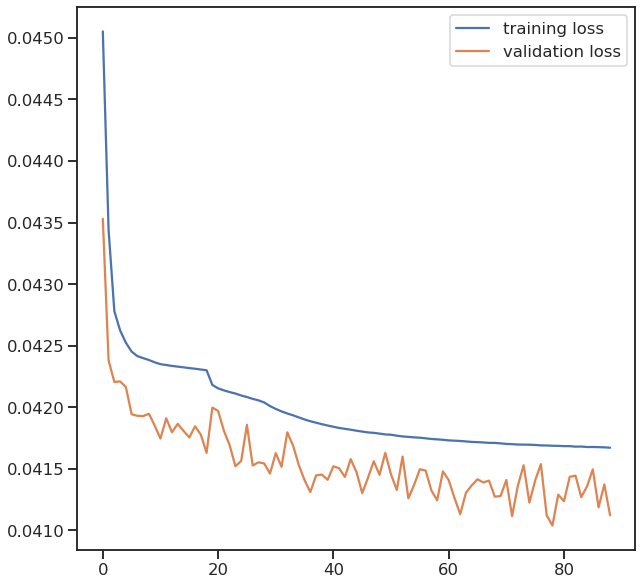

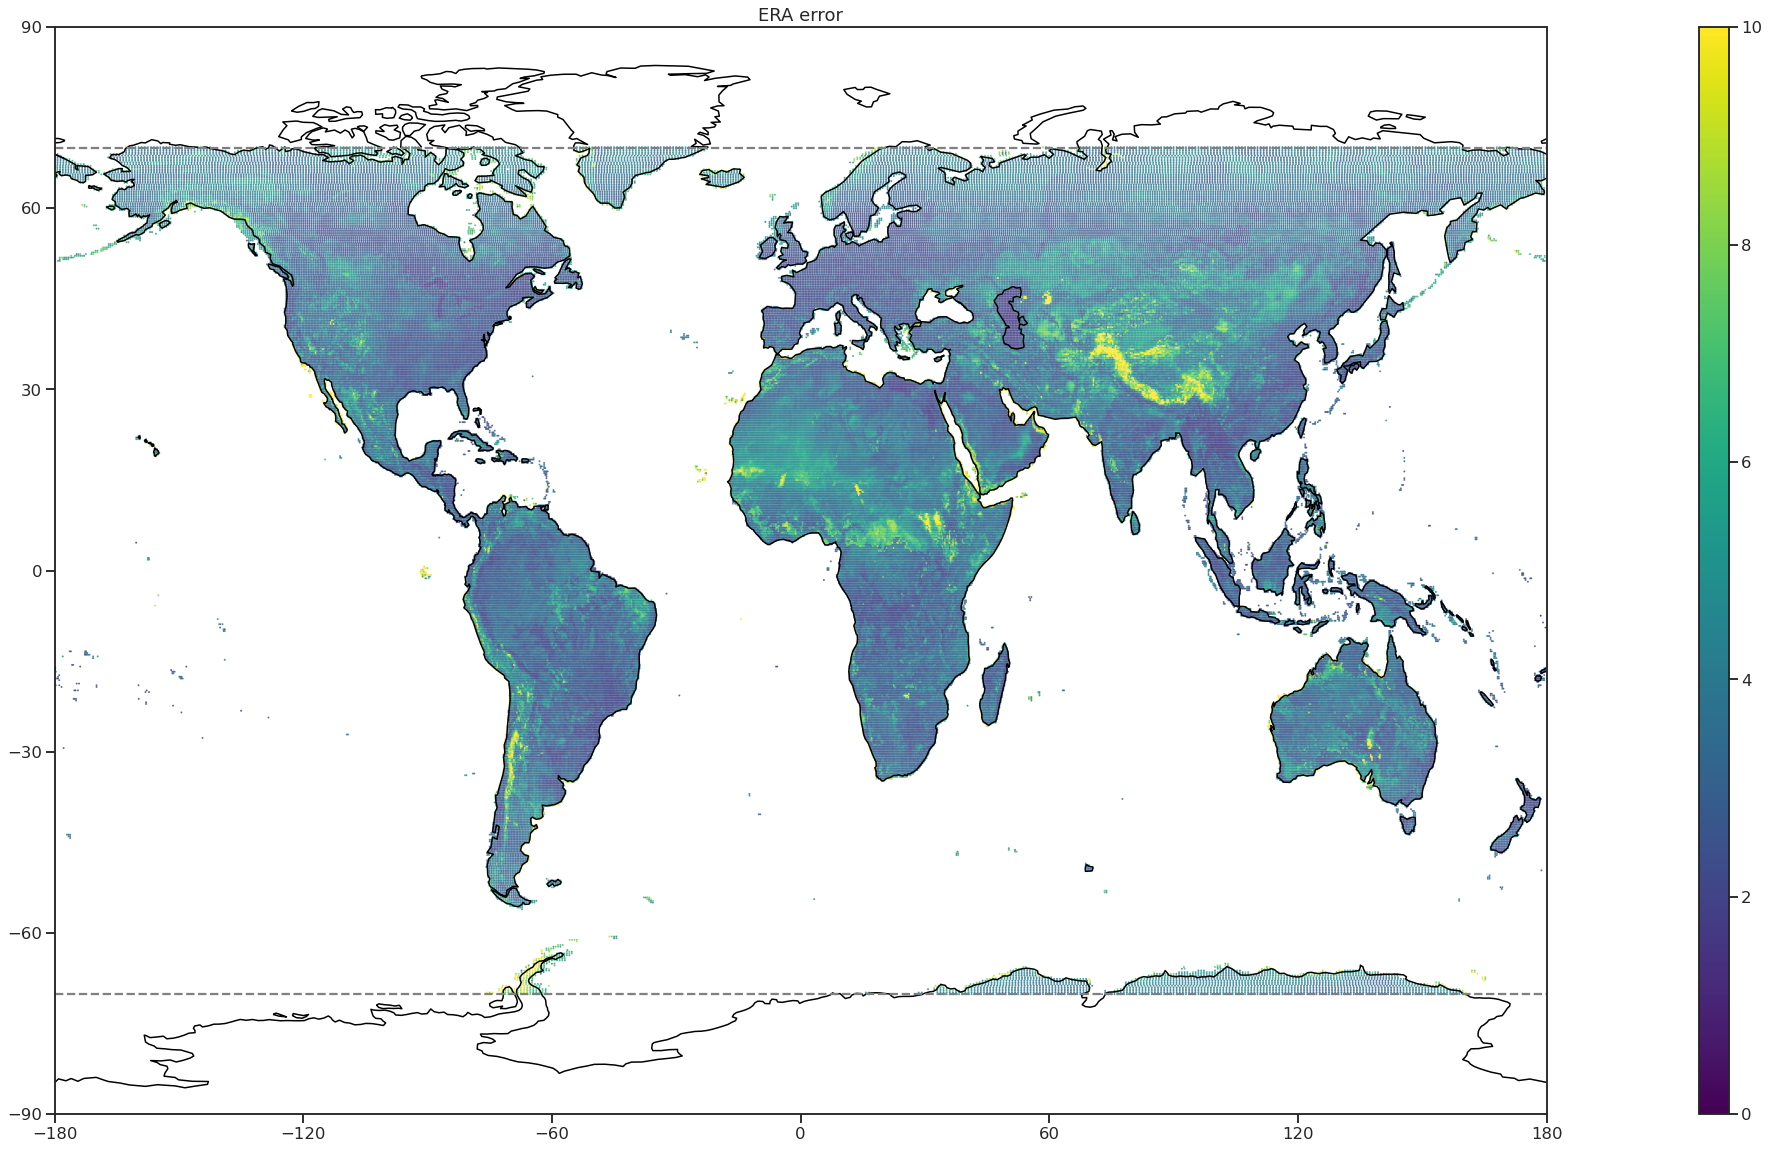

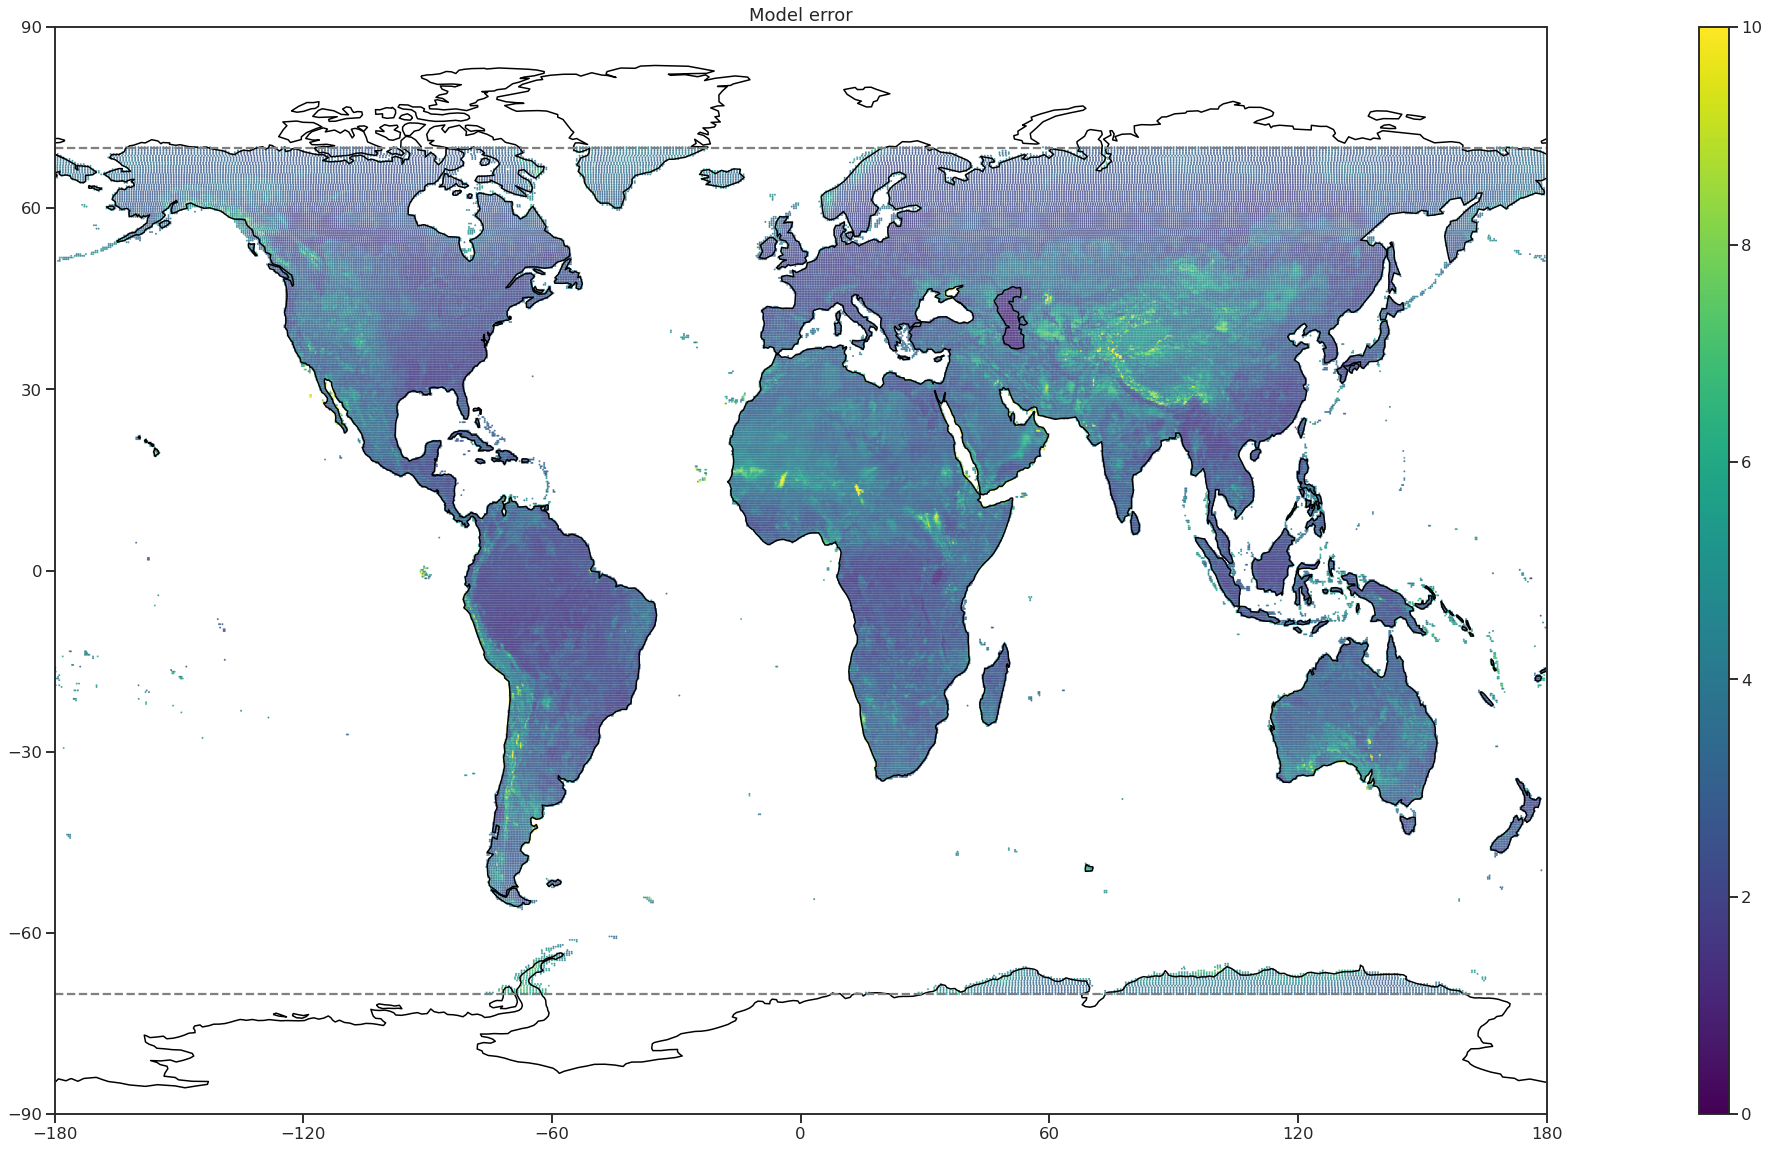

In [270]:
#Trained models
models_root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/processed_data/trained_models/'



#example_model = 'ML_b6f1b47c51ad4b6c8f05748ea9f55fd2/' #original example
example_model = 'ML_d5314d4d6a0b411095f941f178907e5e/' #v20 lakes example

#Load the data
path = models_root+example_model
df = load_predictions(path,print_errors=True)

#Plot the training history
plot_training_history(path,logscale=False,jump_n_epochs=1)

#Group by lat/long i.e. average over time
df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()
plot_map(df_grouped,'error_ERA_abs',vmin=0,vmax=10,cmap=plt.cm.viridis,logscale=False,title='ERA error',limits=None)
plot_map(df_grouped,'error_NN_abs',vmin=0,vmax=10,cmap=plt.cm.viridis,logscale=False,title='Model error',limits=None)


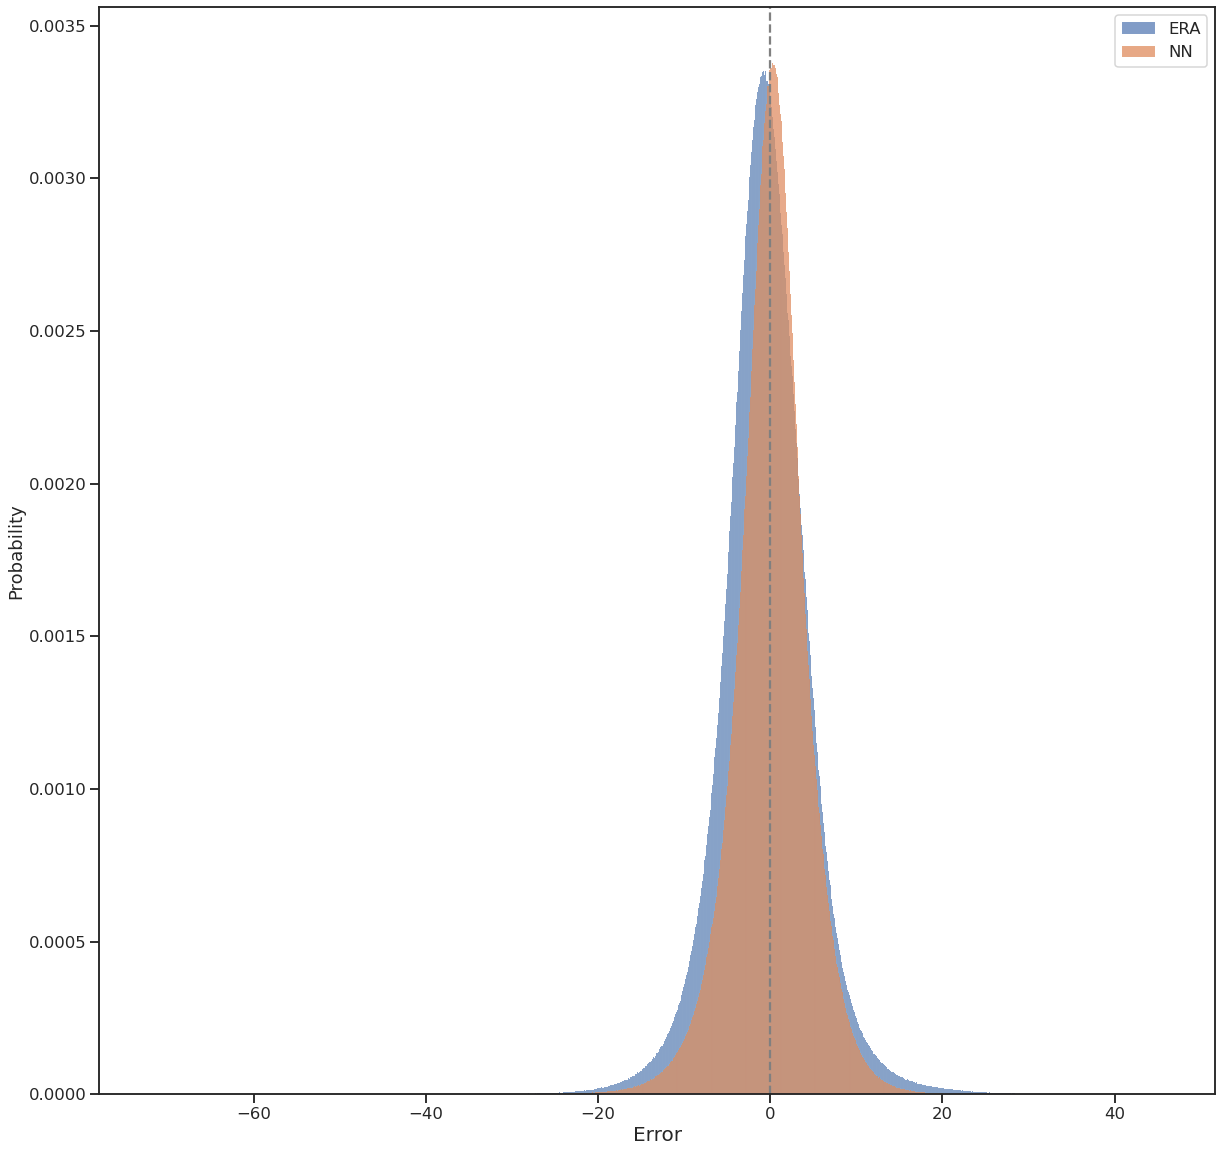

CPU times: user 1min 50s, sys: 7.44 s, total: 1min 57s
Wall time: 1min 57s


In [271]:
%%time

#Plot distribution of errors
#This is quite slow, ~1-2 mins

#Setup plot env
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )


#Figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))






sns.histplot(df['error_ERA'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0',label='ERA')
sns.histplot(df['error_NN'], bins='auto', stat='probability',kde=False,alpha=0.7,color='C1',label='NN')


# Config
ax1.set_xlabel('Error', fontsize = 20)
ax1.legend().set_title(None)
ax1.axvline(0,c='0.5', linestyle='--')




plt.show()


# APPENDIX

In [11]:
import pandas as pd

root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/' 
df = pd.read_parquet(f'{root}processed_data/joined_data/2016_ML.parquet')

In [12]:
dfog = df.copy()

In [15]:

df['clake_monthly_value'] = df['clake_monthly_value'].clip(lower=0)

In [16]:
df

sp       msl       u10       v10       t2m     aluvp     aluvd  \
0        0.871381  0.069685 -0.217872 -0.949690 -0.606072 -0.405093 -0.468145   
1        0.868317  0.080809 -0.287266 -1.010882 -0.607895 -0.405093 -0.468145   
2        0.830411  0.113008  1.309720  0.316661 -0.528342 -0.405093 -0.468145   
3        0.803400  0.102470  1.501936  0.299323 -0.540993 -0.405093 -0.468145   
4        0.925290  0.832217  2.742740 -1.171004 -0.365817 -0.405093 -0.468145   
...           ...       ...       ...       ...       ...       ...       ...   
3011667  0.996271  1.173014  2.265333  0.176491 -1.829209 -0.405112 -0.468165   
3011668  0.985716  1.173600  2.505757 -0.401101 -1.835250 -0.405112 -0.468165   
3011669  0.931807  1.176820  2.693367 -0.782196 -1.883005 -0.405112 -0.468165   
3011670  0.931013  1.163940  2.973093 -1.040225 -1.899987 -0.405112 -0.468165   
3011671  0.960634  1.148719  3.134603 -1.281937 -1.901468 -0.405112 -0.468165   

            alnip    alnid      istl1  ...  si10_v20  anor_v20    cl_v20  \
0       -1.542554 -1.69344   0.053420  ... -0.026674  0.002432  0.045152   
1       -1.542554 -1.69344   0.053420  ... -0.026674  0.002432  0.086943   
2       -1.542554 -1.69344   0.053420  ... -0.026674  0.002432  0.329216   
3       -1.542554 -1.69344   0.053420  ... -0.026674  0.002432  0.813120   
4       -1.542554 -1.69344   0.053420  ... -0.026674  0.002432  0.237891   
...           ...      ...        ...  ...       ...       ...       ...   
3011667 -1.542560 -1.69344 -12.166594  ... -0.026674  0.002432  0.921453   
3011668 -1.542560 -1.69344 -12.246882  ... -0.026674  0.002432  0.047656   
3011669 -1.542560 -1.69344 -12.767239  ... -0.026674  0.002432  0.373846   
3011670 -1.542560 -1.69344 -13.008106  ... -0.026674  0.002432  0.313171   
3011671 -1.542560 -1.69344 -13.059939  ... -0.026674  0.002432  0.057198   

           dl_v20     z_v20  slor_v20  clake_monthly_value  cl_saline  \
0        0.310372  0.093001 -0.013803             0.000000  -0.063803   
1       -0.221121  0.302541 -0.013803             0.000000  -0.063803   
2       -1.650934 -0.134667 -0.013803             0.377642  -0.063803   
3        0.411411 -0.487975 -0.013803             0.514276  -0.063803   
4        0.302283 -0.189898 -0.013803             0.000000  -0.063803   
...           ...       ...       ...                  ...        ...   
3011667  0.286667  0.134741 -0.013803             0.000000  -0.063803   
3011668  0.253569  0.140643 -0.013803             0.000000  -0.063803   
3011669  0.216578  0.430288 -0.013803             0.000000  -0.063803   
3011670  0.176816  0.102277 -0.013803             0.000000  -0.063803   
3011671  0.252686  0.038614 -0.013803             0.000000  -0.063803   

         cl_saline_max   MODIS_LST  
0             -0.06977  286.653992  
1             -0.06977  283.438171  
2             -0.06977  288.733185  
3             -0.06977  289.983276  
4             -0.06977  293.384369  
...                ...         ...  
3011667       -0.06977  258.804779  
3011668       -0.06977  258.174957  
3011669       -0.06977  257.600525  
3011670       -0.06977  258.027435  
3011671       -0.06977  256.001099  

[37479935 rows x 45 columns]

In [35]:
df = pd.DataFrame({'latitude': [10,20,30,40,10],
                   'longitude': [10,20,30,40,10],
                   'A' : [1,2,1,2,9],
                   'B' : [1,2,3,4,8]})
df_grouped = df.groupby(['latitude', 'longitude']).mean()

In [36]:
df.value_counts(subset=['latitude', 'longitude']) 

latitude  longitude
10        10           2
20        20           1
30        30           1
40        40           1
dtype: int64

In [32]:
df_grouped

latitude  longitude    A    B
0        10         10  5.0  4.5
1        20         20  2.0  2.0
2        30         30  1.0  3.0
3        40         40  2.0  4.0

In [23]:
df.groupby(['latitude', 'longitude']).count()

A  B
latitude longitude      
10       10         2  2
20       20         1  1
30       30         1  1
40       40         1  1

In [63]:
 
#     process_data False
# join_data  True
# prep_ML    False
# train_model False
# predict
    
    
dicto =     {'process_data': True,
                   'join_data': False,
                   'prep_ML' : False,
                   'train_model' : True,
            'predict' : True}
    
    
for k, v in dicto.items():
    print(f'{k : <15} {v}')

process_data    True
join_data       False
prep_ML         False
train_model     True
predict         True


In [51]:
# assigning strings to the variables
left_alignment = "Left Text"
center_alignment = "Centered Text"
right_alignment = "Right Text"
  
# printing out aligned text
print(f"{left_alignment : <20}{center_alignment : ^15}{right_alignment : >20}")

Left Text            Centered Text           Right Text


In [64]:
70000 % 2

0

In [65]:
training_features = ['A', 'B', 'C', 'D'] #.remove(permuted_feature)


In [69]:
training_features.remove(None)

ValueError: list.remove(x): x not in list

In [75]:
try:
    training_features.remove('B')
except:
    pass



In [76]:
training_features

['C', 'D']

In [77]:
all_features = [1,2,3,4,5]
all_scores = [6,7,8,9,10]

In [79]:
df = pd.DataFrame(data = {'features': all_features, 'scores': all_scores})

In [80]:
df

features  scores
0         1       6
1         2       7
2         3       8
3         4       9
4         5      10

In [83]:
for f in training_features + ['Model']:
    print (f)

C
D
Model


In [86]:
list=['abra','babab','cafaf','ddfdf','edaffd','fdfdfaf','gdfad','hdadfa', 'i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

    for i in range(0, len(list), 5):
        print(*list[i:i+5], sep=' ')

abra babab cafaf ddfdf edaffd
fdfdfaf gdfad hdadfa i j
k l m n o
p q r s t
u v w x y
z


In [88]:
dict = {'validation_data': None, 'model': None, '_chief_worker_only': None, '_supports_tf_logs': False, 'monitor': 'val_loss', 'patience': 20, 'verbose': 1, 'baseline': None, 'min_delta': 0, 'wait': 0 } 

In [89]:
dict

{'validation_data': None,
 'model': None,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'monitor': 'val_loss',
 'patience': 20,
 'verbose': 1,
 'baseline': None,
 'min_delta': 0,
 'wait': 0}

In [91]:
for k, v in dict.items():
    print(f'{k : <30} {v}')

validation_data                None
model                          None
_chief_worker_only             None
_supports_tf_logs              False
monitor                        val_loss
patience                       20
verbose                        1
baseline                       None
min_delta                      0
wait                           0


In [120]:
blob = ['sp', 'msl', 'u10', 'v10', 't2m', 'aluvp', 'aluvd', 'alnip', 'alnid', 'istl1', 'istl2', 'sd', 'd2m', 'fal', 'skt', 'slt_v15', 'sdfor_v15', 'sdor_v15', 'cvl_v15', 'lsm_v15', 'isor_v15', 'tvl_v15', 'tvh_v15', 'cvh_v15', 'si10_v15', 'anor_v15', 'cl_v15', 'dl_v15', 'z_v15', 'slor_v15', 'sdor_v20', 'cvl_v20', 'lsm_v20', 'isor_v20', 'cvh_v20', 'si10_v20', 'anor_v20', 'cl_v20', 'dl_v20', 'z_v20', 'slor_v20', 'clake_monthly_value', 'cl_saline_max']

In [121]:
newblob = blob.remove('sp')

In [122]:
newblob

In [124]:
if 'sp' in blob: x = blob.remove('sp')

In [125]:
x

In [126]:
import pandas as pd

In [127]:
df = pd.read_parquet('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/ThrowawayFeatImport/scores.parquet')

In [128]:
df

features                     scores
0    Model   [20.59275245666504, 0.0]
1  cvl_v20  [20.677669525146484, 0.0]
2  cvh_v20  [20.120248794555664, 0.0]

In [194]:
import xarray as xr


original_sfc_file = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_sfc/sfc_unstructured_2016_02.grib' #Feb 2016
#new_sfc_file = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_sfc/sfc_unstructured_2015_02.grib' #Feb 2015
new_sfc_file = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/BonusERA/sfc_unstructured_2015_01.grib'

In [195]:
#ds_original = xr.open_dataset(original_sfc_file,engine='cfgrib',backend_kwargs={'indexpath': ''})
ds_new = xr.open_dataset(new_sfc_file,engine='cfgrib',backend_kwargs={'indexpath': ''})


In [196]:
#display(ds_original)
display(ds_new)

<xarray.Dataset>
Dimensions:     (time: 744, values: 542080)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-01-31T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (values) float64 ...
    longitude   (values) float64 ...
    valid_time  (time) datetime64[ns] ...
Dimensions without coordinates: values
Data variables:
    u10         (time, values) float32 ...
    v10         (time, values) float32 ...
    sp          (time, values) float32 ...
    msl         (time, values) float32 ...
    t2m         (time, values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-05-31T12:59 GRIB to CDM+CF via cfgrib-0.9.1...

In [207]:
#What about december 
dec_file =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/BonusERA/sfc_unstructured_2015_03.grib' 
ds_dec = xr.open_dataset(dec_file,engine='cfgrib',backend_kwargs={'indexpath': ''})

In [208]:
display(ds_dec)

<xarray.Dataset>
Dimensions:     (time: 62, step: 12, values: 542080)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2015-03-01T06:00:00 ... 2015-03-31T18:0...
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 11:00:00 12:00:00
    surface     float64 ...
    latitude    (values) float64 ...
    longitude   (values) float64 ...
    valid_time  (time, step) datetime64[ns] ...
Dimensions without coordinates: values
Data variables:
    u10         (time, step, values) float32 ...
    v10         (time, step, values) float32 ...
    sp          (time, step, values) float32 ...
    msl         (time, step, values) float32 ...
    t2m         (time, step, values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-05-31T13:22 GRIB to CDM+CF via cfgrib-0.9.1...

In [191]:
#What about skt?
skt_file_old = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skt_tom/skt_unstructured_2016_01.grib' 
skt_file_new = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skt_tom/skt_unstructured_2015_01.grib' 


In [192]:
ds_skt_old = xr.open_dataset(skt_file_old,engine='cfgrib',backend_kwargs={'indexpath': ''})
ds_skt_new = xr.open_dataset(skt_file_new,engine='cfgrib',backend_kwargs={'indexpath': ''})


In [193]:
display(ds_skt_old)
display(ds_skt_new)

<xarray.Dataset>
Dimensions:     (time: 744, values: 542080)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2016-01-01 ... 2016-01-31T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (values) float64 ...
    longitude   (values) float64 ...
    valid_time  (time) datetime64[ns] ...
Dimensions without coordinates: values
Data variables:
    skt         (time, values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-05-31T10:14 GRIB to CDM+CF via cfgrib-0.9.1...

<xarray.Dataset>
Dimensions:     (time: 744, values: 542080)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-01-31T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (values) float64 ...
    longitude   (values) float64 ...
    valid_time  (time) datetime64[ns] ...
Dimensions without coordinates: values
Data variables:
    skt         (time, values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-05-31T10:14 GRIB to CDM+CF via cfgrib-0.9.1...

In [211]:
import xarray as xr
#f1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_sfc/sfc_unstructured_2016_02.grib'
f2 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2015_01.grib'
#f3 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skt_tom/skt_unstructured_2015_01.grib'

#ds1 = xr.open_dataset(f1,engine='cfgrib',backend_kwargs={'indexpath': ''})













In [212]:
ds1 = xr.open_dataset(f2,engine='cfgrib',backend_kwargs={'indexpath': ''})


skipping variable: paramId==36 shortName='istl2'
Traceback (most recent call last):
  File "/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/cfgrib/dataset.py", line 593, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


In [214]:
ds1.d2m

<xarray.DataArray 'd2m' (time: 744, values: 542080)>
[403307520 values with dtype=float32]
Coordinates:
    number               int64 0
  * time                 (time) datetime64[ns] 2015-01-01 ... 2015-01-31T23:0...
    step                 timedelta64[ns] 00:00:00
    surface              float64 0.0
    latitude             (values) float64 ...
    longitude            (values) float64 ...
    valid_time           (time) datetime64[ns] 2015-01-01 ... 2015-01-31T23:0...
    depthBelowLandLayer  float64 0.0
Dimensions without coordinates: values
Attributes:
    GRIB_paramId:                    168
    GRIB_dataType:                   an
    GRIB_numberOfPoints:             542080
    GRIB_typeOfLevel:                surface
    GRIB_stepUnits:                  1
    GRIB_stepType:                   instant
    GRIB_gridType:                   reduced_gg
    GRIB_N:                          320
    GRIB_NV:                         0
    GRIB_cfName:                     unknown
    GRIB_cfVarName:                  d2m
    GRIB_gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    GRIB_missingValue:               9999
    GRIB_name:                       2 metre dewpoint temperature
    GRIB_pl:                         [  18   25   36   40   45   50   60   64...
    GRIB_shortName:                  2d
    GRIB_totalNumber:                0
    GRIB_units:                      K
    long_name:                       2 metre dewpoint temperature
    units:                           K
    standard_name:                   unknown

In [144]:
ds3 = xr.open_dataset(f3,engine='cfgrib',backend_kwargs={'indexpath': ''})


In [178]:
ds1.valid_time

<xarray.DataArray 'valid_time' (time: 696)>
array(['2016-02-01T00:00:00.000000000', '2016-02-01T01:00:00.000000000',
       '2016-02-01T02:00:00.000000000', ..., '2016-02-29T21:00:00.000000000',
       '2016-02-29T22:00:00.000000000', '2016-02-29T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2016-02-01 ... 2016-02-29T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  (time) datetime64[ns] 2016-02-01 ... 2016-02-29T23:00:00
Attributes:
    standard_name:  time
    long_name:      time

In [156]:
dsstack = ds1.stack(station_date=['time', 'step'])
#ds1['tnew'] = ds1.timeds1.step

In [159]:
dsstack

<xarray.Dataset>
Dimensions:       (values: 542080, station_date: 744)
Coordinates:
    number        int64 0
    surface       float64 0.0
    latitude      (values) float64 ...
    longitude     (values) float64 ...
    valid_time    (station_date) datetime64[ns] 2015-01-01T07:00:00 ... 2015-...
  * station_date  (station_date) MultiIndex
  - time          (station_date) datetime64[ns] 2015-01-01T06:00:00 ... 2015-...
  - step          (station_date) timedelta64[ns] 01:00:00 02:00:00 ... 12:00:00
Dimensions without coordinates: values
Data variables:
    u10           (values, station_date) float32 -9.062 -9.044 ... -4.097 -4.162
    v10           (values, station_date) float32 -2.984 -2.85 ... -0.4296
    sp            (values, station_date) float32 1.021e+05 ... 6.93e+04
    msl           (values, station_date) float32 1.021e+05 ... 1.003e+05
    t2m           (values, station_date) float32 247.6 247.9 ... 238.3 238.4
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-05-30T16:42 GRIB to CDM+CF via cfgrib-0.9.1...

In [175]:
ds3.time

<xarray.DataArray 'time' (time: 744)>
array(['2015-01-01T00:00:00.000000000', '2015-01-01T01:00:00.000000000',
       '2015-01-01T02:00:00.000000000', ..., '2015-01-31T21:00:00.000000000',
       '2015-01-31T22:00:00.000000000', '2015-01-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-01-31T23:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  (time) datetime64[ns] 2015-01-01 ... 2015-01-31T23:00:00
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [169]:
sum(ds3.valid_time == ds3.time)

<xarray.DataArray ()>
array(744)
Coordinates:
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  float64 0.0

In [202]:
df = pd.DataFrame({'A':range(10), 'B':range(10)})
df

A  B
0  0  0
1  1  1
2  2  2
3  3  3
4  4  4
5  5  5
6  6  6
7  7  7
8  8  8
9  9  9

In [203]:
import numpy as np
df['A'] = np.random.permutation(df['A'])


In [204]:
df

A  B
0  3  0
1  1  1
2  4  2
3  7  3
4  5  4
5  2  5
6  6  6
7  8  7
8  9  8
9  0  9

# Compare joined files

In [3]:
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/'
og_file = root + 'Haversine_MODIS_ERA_2016_01.parquet'
new_file = root + 'RapidsHaversine_MODIS_ERA_2016_01.parquet'

In [2]:
import pandas as pd

In [217]:
df_og = pd.read_parquet(og_file, columns=['latitude_ERA', 'longitude_ERA'])

In [4]:
df_new = pd.read_parquet(new_file)

In [225]:
df_og

latitude_ERA  longitude_ERA
0      -52.412155     168.888889
1      -52.412155     169.333333
2      -50.725974     165.833333
3      -50.725974     166.250000
4      -47.353611     167.600000
..            ...            ...
954     70.117048    -145.500000
955     70.117048    -144.750000
956     70.117048    -144.000000
957     70.117048    -143.250000
958     70.117048    -142.500000

[3023211 rows x 2 columns]

In [6]:
df_new

latitude_MODIS  longitude_MODIS   MODIS_LST  \
latitude_ERA longitude_ERA                                                
54.660397    -163.59375          54.694444      -163.672222  268.034760   
             -163.12500          54.736667      -163.176667  272.575195   
54.941427    -163.59375          54.816667      -163.816667  264.893341   
             -163.12500          55.016667      -163.216667  269.294556   
55.222457    -163.12500          55.126923      -163.088462  272.096771   
...                                    ...              ...         ...   
70.117048    -145.50000          69.983333      -145.500000  252.957413   
             -144.75000          69.983333      -144.450000  249.335587   
             -144.00000          69.983333      -144.000000  248.911713   
             -143.25000          69.983333      -143.250000  248.547333   
             -142.50000          69.983333      -142.733333  248.161880   

                                       sp          msl       u10       v10  \
latitude_ERA longitude_ERA                                                   
54.660397    -163.59375      96508.593750   98497.7500 -0.806290 -1.336243   
             -163.12500      97992.593750   98470.2500 -4.911758 -1.014954   
54.941427    -163.59375      96835.593750   98518.5000 -1.604141  0.677429   
             -163.12500      97819.593750   98511.5000 -4.825821  0.520203   
55.222457    -163.12500      98657.593750   98545.7500 -3.980118  0.379578   
...                                   ...          ...       ...       ...   
70.117048    -145.50000     101762.578125  101625.1875  3.144318  1.742966   
             -144.75000     101684.578125  101637.6875  2.966583  1.425583   
             -144.00000     101229.578125  101648.6875  2.462677  1.939255   
             -143.25000     101243.578125  101659.4375  1.289825  3.090622   
             -142.50000     101524.578125  101674.4375  0.183380  2.854294   

                                   t2m     aluvp     aluvd  ...    cl_v20  \
latitude_ERA longitude_ERA                                  ...             
54.660397    -163.59375     270.596405  0.050104  0.055188  ...  0.004295   
             -163.12500     276.477264  0.059992  0.060009  ...  0.001158   
54.941427    -163.59375     272.406952  0.046763  0.052594  ...  0.007089   
             -163.12500     276.219452  0.059992  0.060009  ...  0.009117   
55.222457    -163.12500     275.949921  0.059992  0.060009  ...  0.011388   
...                                ...       ...       ...  ...       ...   
70.117048    -145.50000     259.746033  0.059994  0.060005  ...  0.038720   
             -144.75000     259.722595  0.059994  0.060005  ...  0.000111   
             -144.00000     259.542908  0.059994  0.060005  ...  0.014523   
             -143.25000     259.955017  0.059994  0.060005  ...  0.011842   
             -142.50000     260.861267  0.059994  0.060005  ...  0.000532   

                               dl_v20        z_v20  slor_v20  \
latitude_ERA longitude_ERA                                     
54.660397    -163.59375     41.138672  1445.037354  0.039249   
             -163.12500     48.617188   374.197510  0.000100   
54.941427    -163.59375     15.210938  1337.713135  0.036376   
             -163.12500     36.236328   580.713135  0.000100   
55.222457    -163.12500     24.898438   -92.154053  0.000100   
...                               ...          ...       ...   
70.117048    -145.50000     16.535156  -102.337646  0.000100   
             -144.75000     18.943359   -33.888428  0.000100   
             -144.00000     14.719727   320.756104  0.000100   
             -143.25000     14.961914   314.556885  0.000100   
             -142.50000     32.393555   112.033447  0.000100   

                            clake_monthly_value  cl_saline  heightAboveGround  \
latitude_ERA longitude_ERA                                                      
54.660397    -163.59375                0